## Data Visualization

In [1]:
import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the processed dataset
df = pd.read_csv('../data/dataset_domestic_processed.csv')

### Studio

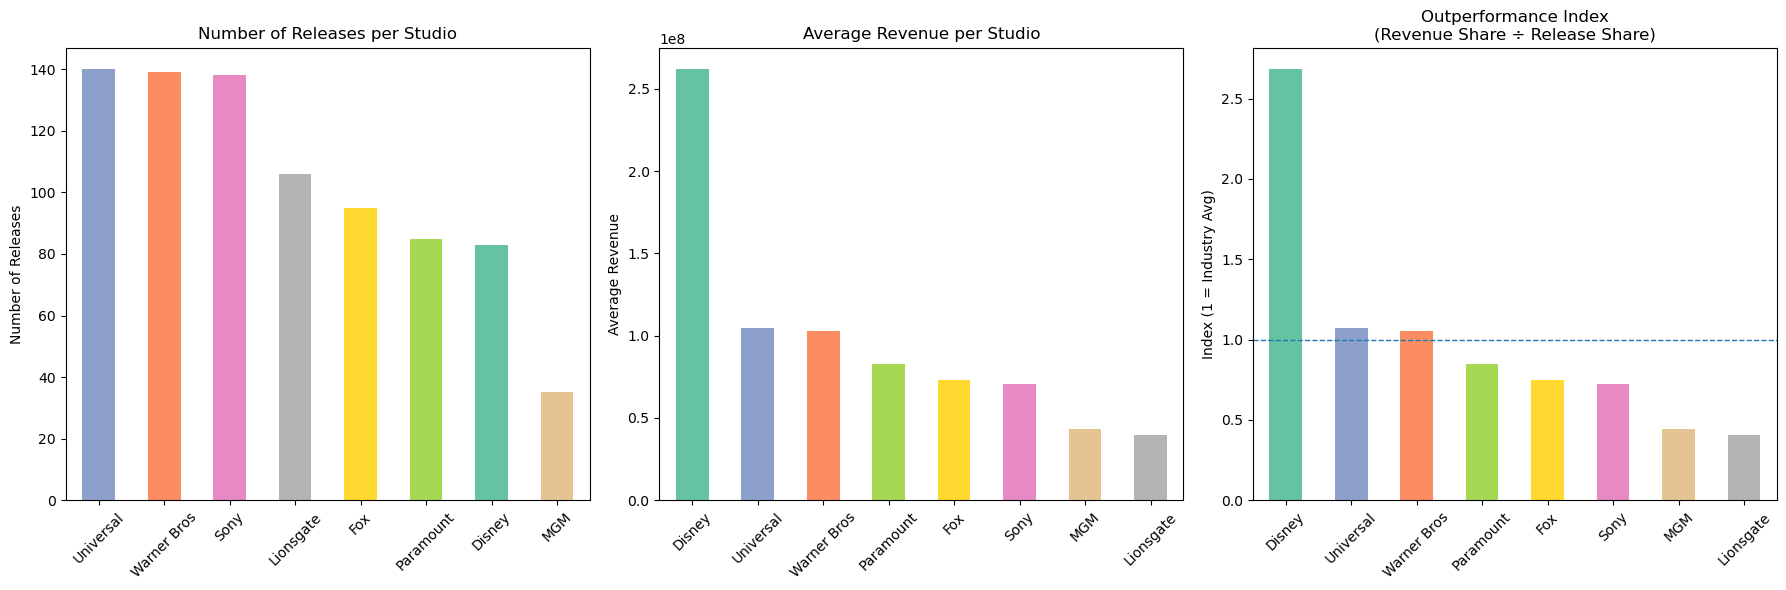

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Number of releases per studio ---
studio_counts = {
    "Disney": df['is_disney'].sum(),
    "Warner Bros": df['is_warner_bros'].sum(),
    "Universal": df['is_universal'].sum(),
    "Sony": df['is_sony'].sum(),
    "Paramount": df['is_paramount'].sum(),
    "Fox": df['is_fox'].sum(),
    "MGM": df['is_mgm'].sum(),
    "Lionsgate": df['is_lionsgate'].sum()
}
studio_counts = pd.Series(studio_counts)

# --- Total revenue per studio ---
studio_total_revenue = {
    "Disney": df.loc[df['is_disney'] == 1, 'revenue'].sum(),
    "Warner Bros": df.loc[df['is_warner_bros'] == 1, 'revenue'].sum(),
    "Universal": df.loc[df['is_universal'] == 1, 'revenue'].sum(),
    "Sony": df.loc[df['is_sony'] == 1, 'revenue'].sum(),
    "Paramount": df.loc[df['is_paramount'] == 1, 'revenue'].sum(),
    "Fox": df.loc[df['is_fox'] == 1, 'revenue'].sum(),
    "MGM": df.loc[df['is_mgm'] == 1, 'revenue'].sum(),
    "Lionsgate": df.loc[df['is_lionsgate'] == 1, 'revenue'].sum()
}
studio_total_revenue = pd.Series(studio_total_revenue)

# --- Average revenue per studio ---
studio_avg_revenue = (studio_total_revenue / studio_counts).sort_values(ascending=False)

# --- Outperformance Index (Revenue Share / Release Share) ---
release_share = studio_counts / studio_counts.sum()
revenue_share = studio_total_revenue / studio_total_revenue.sum()
outperformance_index = (revenue_share / release_share).sort_values(ascending=False)

# --- Consistent colors (Seaborn Set2 palette) ---
# Matches sns.color_palette("Set2", 8)
set2_colors = [
    "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3",
    "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"
]
studios_in_palette_order = ["Disney","Warner Bros","Universal","Sony","Paramount","Fox","MGM","Lionsgate"]
color_map = dict(zip(studios_in_palette_order, set2_colors))

def colors_for_index(index):
    return [color_map.get(s, "#b3b3b3") for s in index]  # fallback gray if any new studio appears

# --- Plot side by side (3 panels) ---
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Left: number of releases
counts_sorted = studio_counts.sort_values(ascending=False)
counts_sorted.plot(kind='bar', ax=axes[0], color=colors_for_index(counts_sorted.index))
axes[0].set_title("Number of Releases per Studio")
axes[0].set_ylabel("Number of Releases")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# Middle: average revenue per release
studio_avg_revenue.plot(kind='bar', ax=axes[1], color=colors_for_index(studio_avg_revenue.index))
axes[1].set_title("Average Revenue per Studio")
axes[1].set_ylabel("Average Revenue")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

# Right: outperformance index
outperformance_index.plot(kind='bar', ax=axes[2], color=colors_for_index(outperformance_index.index))
axes[2].set_title("Outperformance Index\n(Revenue Share ÷ Release Share)")
axes[2].set_ylabel("Index (1 = Industry Avg)")
axes[2].axhline(1, linestyle='--', linewidth=1)  # reference line
axes[2].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()


### Genre

Top 10 genres by number of releases:
 1. Action: 190 movies
 2. Comedy: 110 movies
 3. Horror: 109 movies
 4. Drama: 101 movies
 5. Family: 57 movies
 6. Adventure: 44 movies
 7. Science Fiction: 41 movies
 8. Animation: 41 movies
 9. Thriller: 28 movies
10. Crime: 22 movies


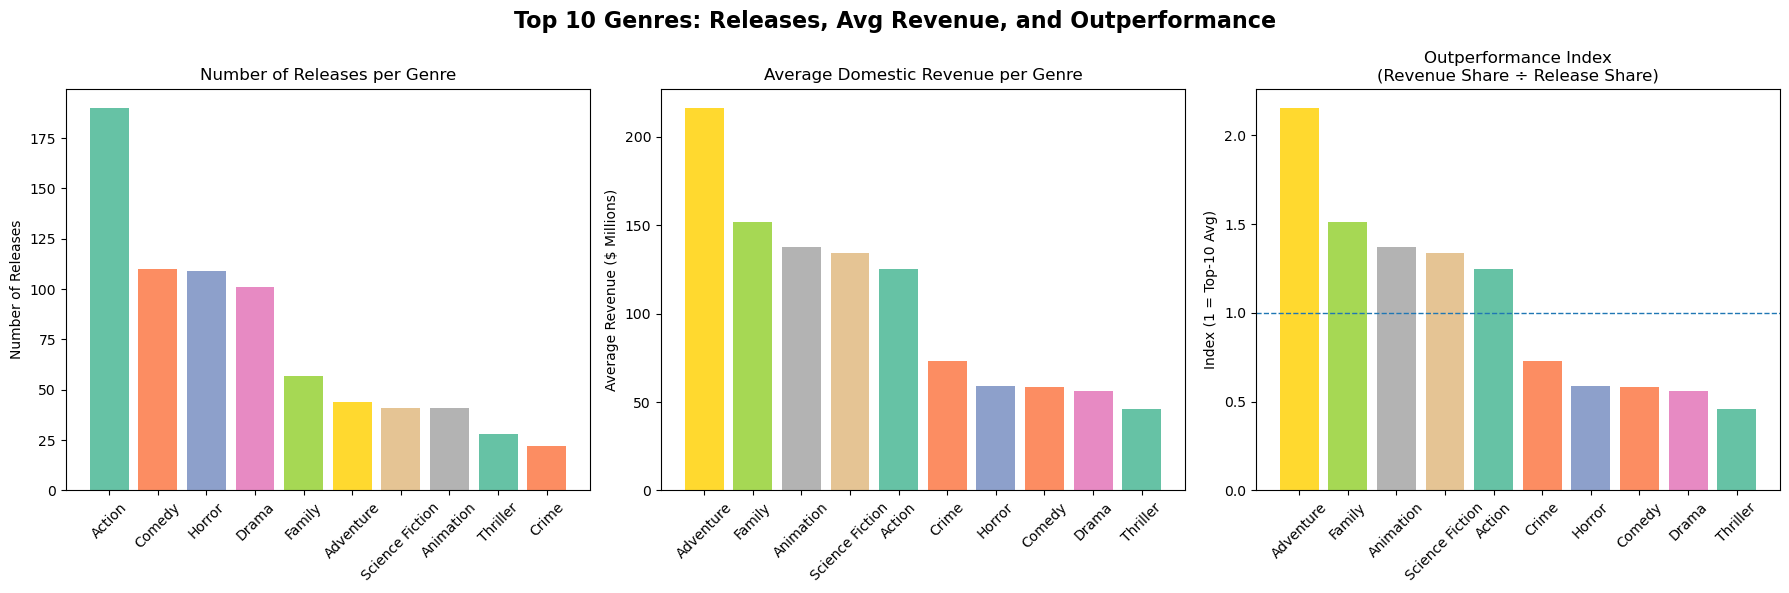

In [4]:
# First, let's identify the top 10 genres by number of releases
top_10_genres = df['primary_genre'].value_counts().head(10).index.tolist()
print("Top 10 genres by number of releases:")
for i, genre in enumerate(top_10_genres, 1):
    count = df['primary_genre'].value_counts()[genre]
    print(f"{i:2d}. {genre}: {count} movies")

import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- Normalize helper (fixes trailing spaces and NBSPs) --------
def norm(s):
    return unicodedata.normalize("NFKC", str(s)).replace("\xa0", " ").strip().lower()

# -------- Rebuild a guaranteed Set2 palette mapped to the *normalized* top_10_genres --------
try:
    import seaborn as sns
    _palette = sns.color_palette("Set2", len(top_10_genres))
except Exception:
    # Fallback: Set2 base + cycle if >8
    base = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3",
            "#a6d854","#ffd92f","#e5c494","#b3b3b3"]
    from itertools import cycle, islice
    _palette = list(islice(cycle(base), len(top_10_genres)))

color_map_norm = dict(zip([norm(g) for g in top_10_genres], _palette))

def colors_for(names):
    # Normalize names before lookup; fall back to gray only if truly unknown
    cols = [color_map_norm.get(norm(n), "#b3b3b3") for n in names]
    # Optional: report any that still miss (should be none now)
    _missing = [n for n in names if norm(n) not in color_map_norm]
    if _missing:
        print("⚠️ Still missing after normalization:", _missing)
    return cols

# -------- Aggregate metrics (Top 10 only) --------
mask_top10 = df['primary_genre'].isin(top_10_genres)

g_counts = (df.loc[mask_top10, 'primary_genre']
              .value_counts()
              .reindex(top_10_genres, fill_value=0))

g_total_rev = (df.loc[mask_top10]
                 .groupby('primary_genre')['revenue_domestic']
                 .sum()
                 .reindex(top_10_genres, fill_value=0))

g_avg_rev = (g_total_rev / g_counts.replace(0, pd.NA)).fillna(0)

release_share = g_counts / g_counts.sum() if g_counts.sum() else g_counts*0
revenue_share = g_total_rev / g_total_rev.sum() if g_total_rev.sum() else g_total_rev*0
g_outperf = (revenue_share / release_share).replace([np.inf, -np.inf], 0).fillna(0)

# -------- Sort for plotting --------
counts_sorted = g_counts.sort_values(ascending=False)
avg_sorted = g_avg_rev.sort_values(ascending=False)
outperf_sorted = g_outperf.sort_values(ascending=False)

# -------- Plots (3 panels) using your Set2 colors --------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Top 10 Genres: Releases, Avg Revenue, and Outperformance', fontsize=16, fontweight='bold')

# Left: Number of releases
axes[0].bar(counts_sorted.index, counts_sorted.values, color=colors_for(counts_sorted.index))
axes[0].set_title("Number of Releases per Genre")
axes[0].set_ylabel("Number of Releases")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# Middle: Average revenue per release (millions)
axes[1].bar(avg_sorted.index, (avg_sorted.values / 1e6), color=colors_for(avg_sorted.index))
axes[1].set_title("Average Domestic Revenue per Genre")
axes[1].set_ylabel("Average Revenue ($ Millions)")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

# Right: Outperformance Index
axes[2].bar(outperf_sorted.index, outperf_sorted.values, color=colors_for(outperf_sorted.index))
axes[2].set_title("Outperformance Index\n(Revenue Share ÷ Release Share)")
axes[2].set_ylabel("Index (1 = Top-10 Avg)")
axes[2].axhline(1.0, linestyle='--', linewidth=1)
axes[2].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

### Release Month and Season

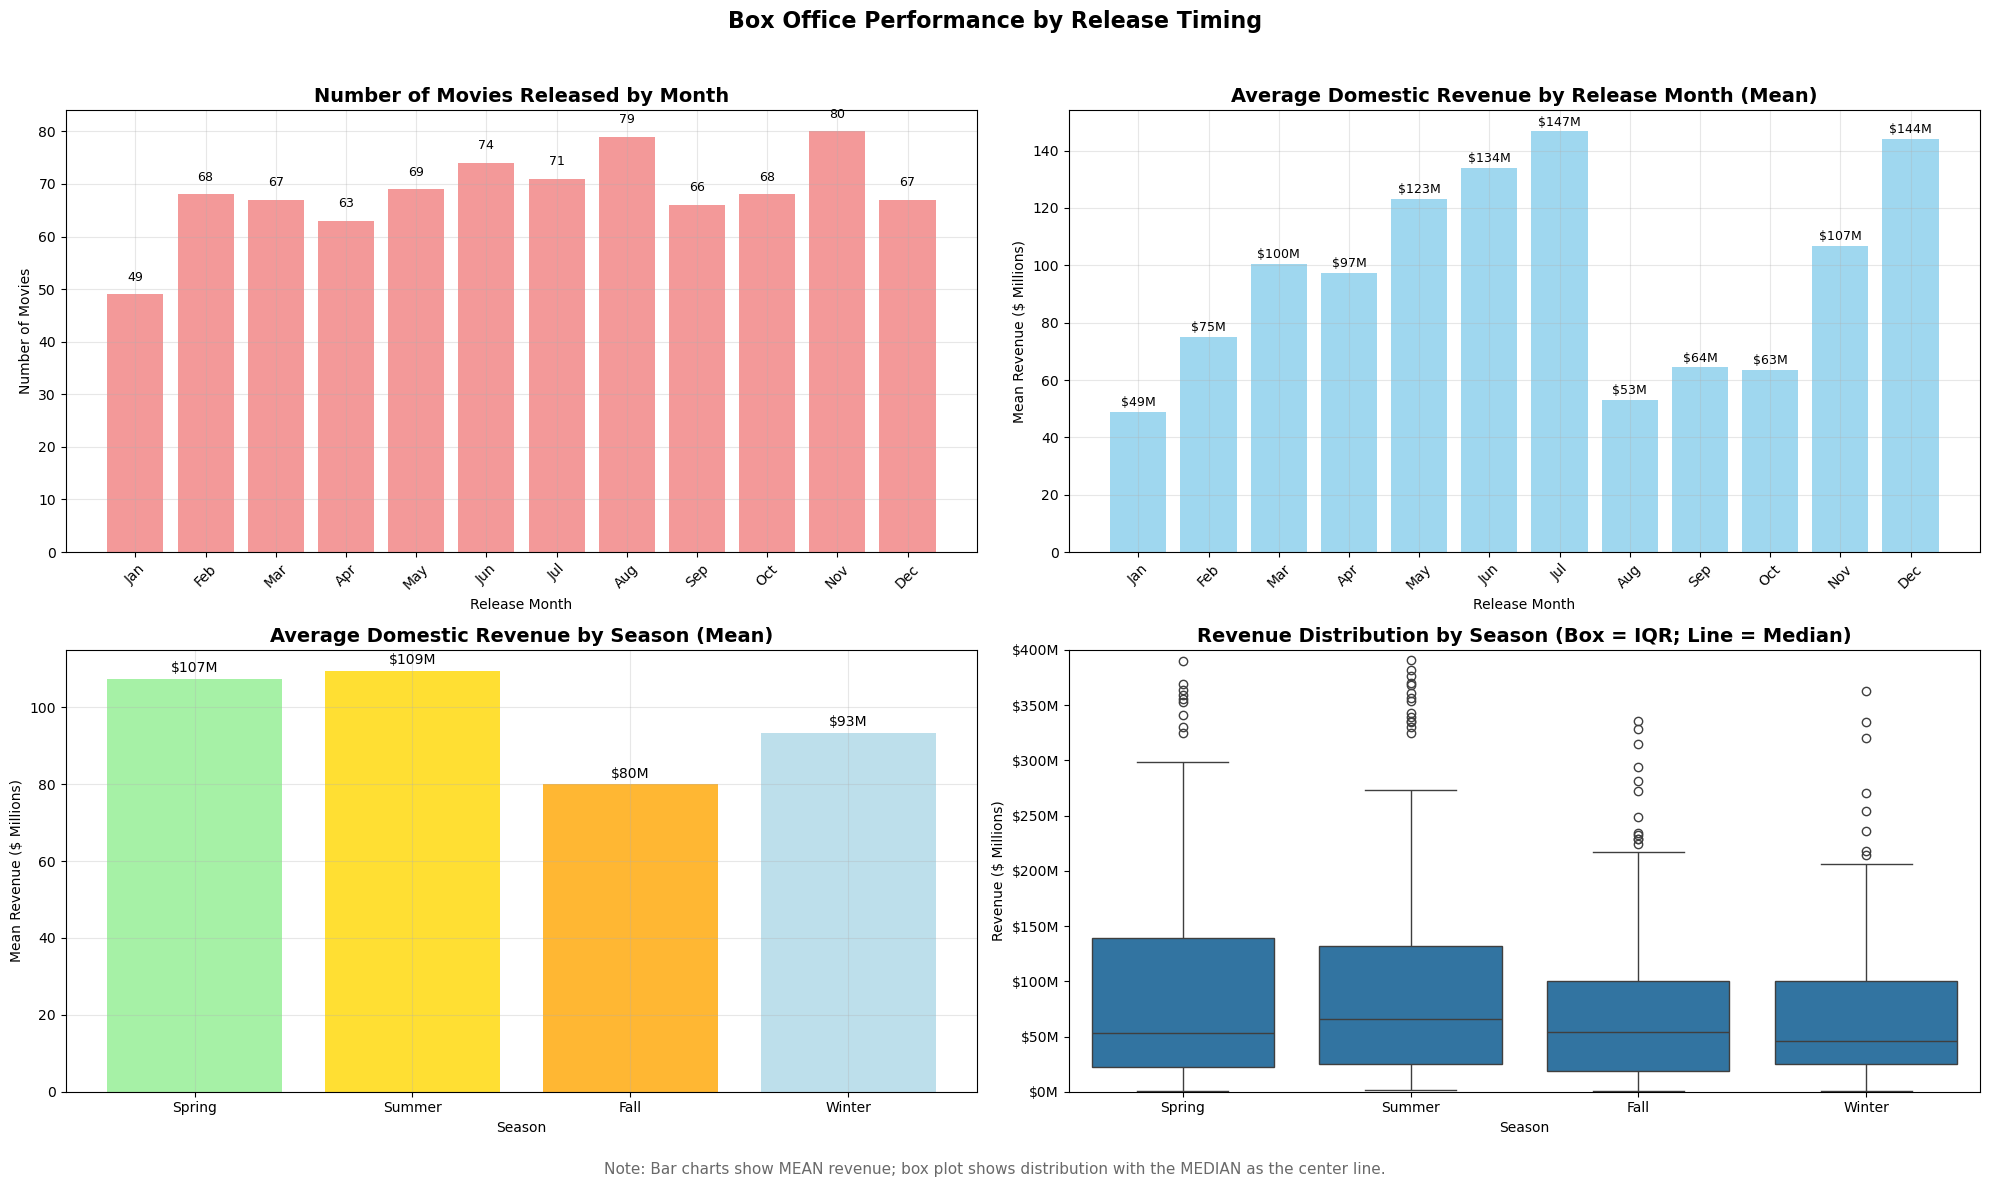

In [5]:
### Release Month and Season Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate monthly and seasonal revenue statistics first
monthly_revenue = df.groupby('release_month').agg({
    'revenue_domestic': ['mean', 'count', 'sum']
}).round(0)
monthly_revenue.columns = ['avg_revenue', 'movie_count', 'total_revenue']

# Reindex to ensure we have all 12 months in order (1-12)
monthly_revenue = monthly_revenue.reindex(range(1, 13), fill_value=0)

# Calculate seasonal revenue statistics
seasonal_revenue = df.groupby('release_season').agg({
    'revenue_domestic': ['mean', 'count', 'sum']
}).round(0)
seasonal_revenue.columns = ['avg_revenue', 'movie_count', 'total_revenue']

# Calculate holiday proximity statistics
holiday_prox_avg = df[df['is_holiday_proximity'] == 1]['revenue_domestic'].mean()
non_holiday_avg = df[df['is_holiday_proximity'] == 0]['revenue_domestic'].mean()

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Box Office Performance by Release Timing', fontsize=16, fontweight='bold')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# --- 1) Number of Movies by Month (TOP-LEFT) ---
ax1 = axes[0, 0]
monthly_counts = monthly_revenue['movie_count'].tolist()  # ordered Jan..Dec
bars1 = ax1.bar(months, monthly_counts, color='lightcoral', alpha=0.8)
ax1.set_title('Number of Movies Released by Month', fontsize=14, fontweight='bold')
ax1.set_xlabel('Release Month')
ax1.set_ylabel('Number of Movies')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
for bar, value in zip(bars1, monthly_counts):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
             f'{int(value)}', ha='center', va='bottom', fontsize=9)

# --- 2) Average Revenue by Month (TOP-RIGHT) — MEAN ---
ax2 = axes[0, 1]
monthly_avg = monthly_revenue['avg_revenue'].tolist()
bars2 = ax2.bar(months, [x/1e6 for x in monthly_avg], color='skyblue', alpha=0.8)
ax2.set_title('Average Domestic Revenue by Release Month (Mean)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Release Month')
ax2.set_ylabel('Mean Revenue ($ Millions)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
for bar, value in zip(bars2, monthly_avg):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'${value/1e6:.0f}M', ha='center', va='bottom', fontsize=9)

# --- 3) Average Revenue by Season (BOTTOM-LEFT) — MEAN ---
ax3 = axes[1, 0]
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
season_colors = ['lightgreen', 'gold', 'orange', 'lightblue']
seasonal_avg = [seasonal_revenue.loc[season, 'avg_revenue'] for season in seasons]
bars3 = ax3.bar(seasons, [x/1e6 for x in seasonal_avg], color=season_colors, alpha=0.8)
ax3.set_title('Average Domestic Revenue by Season (Mean)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Season')
ax3.set_ylabel('Mean Revenue ($ Millions)')
ax3.grid(True, alpha=0.3)
for bar, value in zip(bars3, seasonal_avg):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'${value/1e6:.0f}M', ha='center', va='bottom', fontsize=10)

# --- 4) Revenue Distribution by Season (BOTTOM-RIGHT) — MEDIAN SHOWN ---
ax4 = axes[1, 1]
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
sns.boxplot(data=df, x='release_season', y='revenue_domestic', order=season_order, ax=ax4)
ax4.set_title('Revenue Distribution by Season (Box = IQR; Line = Median)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Season')
ax4.set_ylabel('Revenue ($ Millions)')
ax4.set_ylim(0, 400e6)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

# Figure note to explain difference
fig.text(0.5, 0.01,
         'Note: Bar charts show MEAN revenue; box plot shows distribution with the MEDIAN as the center line.',
         ha='center', fontsize=11, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # leave room for note & suptitle
plt.show()

### Holiday Revenue

/var/folders/zf/7fpxnmz10_vdj37z23fc6vcr0000gn/T/ipykernel_82437/4253145844.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(holiday_group_data, labels=holiday_group_labels)


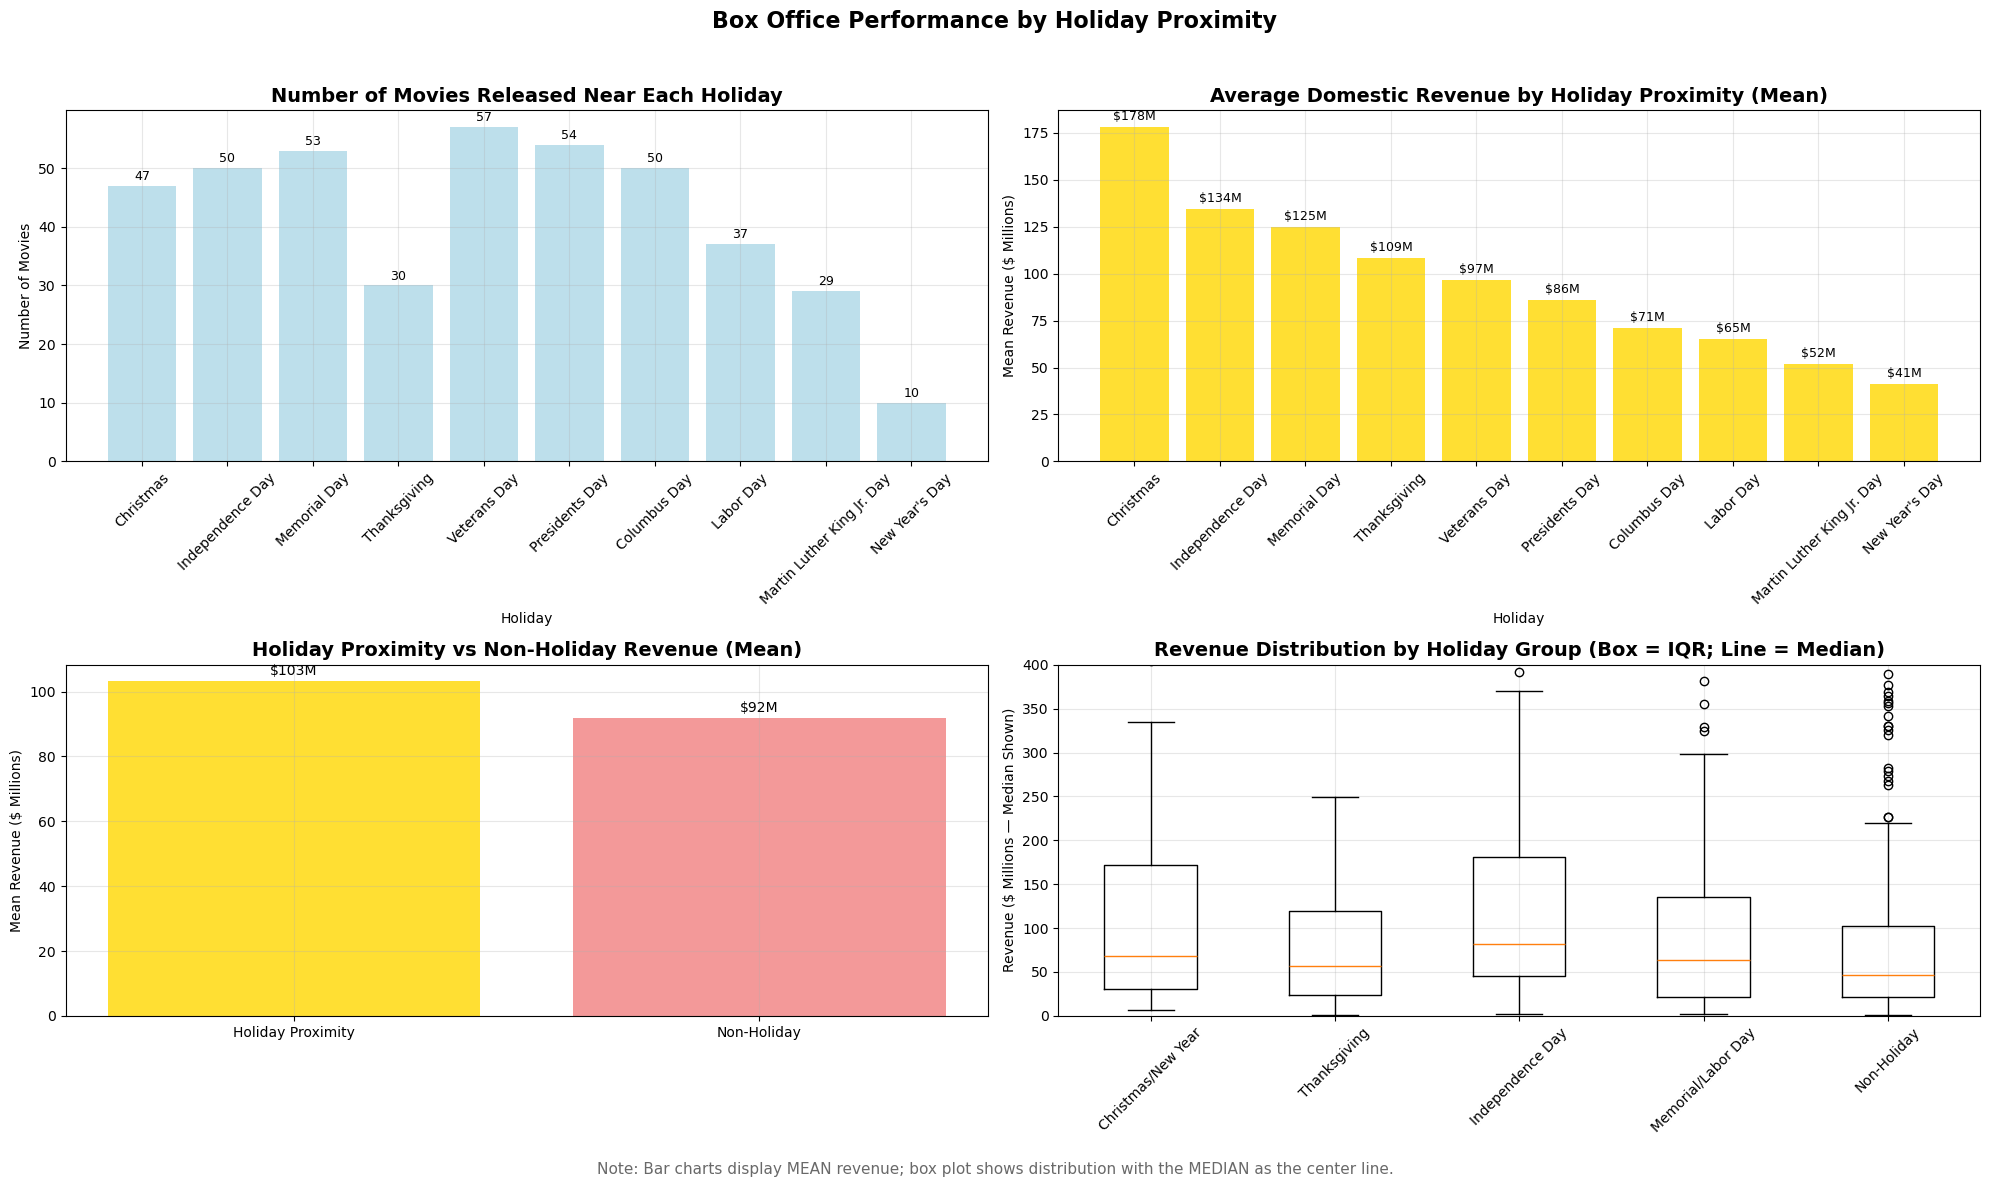

In [6]:
if df['is_holiday_proximity'].sum() > 0:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Prepare holiday revenue data
    holiday_revenue_data = df[df['is_holiday_proximity'] == 1].groupby('nearest_holiday').agg({
        'revenue_domestic': ['mean', 'count', 'sum'],
        'title': 'count'
    }).round(0)
    holiday_revenue_data.columns = ['avg_revenue', 'movie_count', 'total_revenue', 'title_count']
    holiday_revenue_data = holiday_revenue_data[holiday_revenue_data['movie_count'] >= 2]
    # Keep your existing sort (by avg revenue); counts will follow this order
    holiday_revenue_data = holiday_revenue_data.sort_values('avg_revenue', ascending=False)

    if len(holiday_revenue_data) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        fig.suptitle('Box Office Performance by Holiday Proximity', fontsize=16, fontweight='bold')

        holidays = holiday_revenue_data.index

        # --- 1) Number of Movies by Holiday (TOP-LEFT) ---
        ax1 = axes[0, 0]
        movie_counts = holiday_revenue_data['movie_count']
        bars1 = ax1.bar(holidays, movie_counts, color='lightblue', alpha=0.8)
        ax1.set_title('Number of Movies Released Near Each Holiday', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Holiday')
        ax1.set_ylabel('Number of Movies')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        for bar, value in zip(bars1, movie_counts):
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                     f'{int(value)}', ha='center', va='bottom', fontsize=9)

        # --- 2) Average Revenue by Holiday (TOP-RIGHT) — MEAN ---
        ax2 = axes[0, 1]
        avg_revenues = (holiday_revenue_data['avg_revenue'] / 1e6)
        bars2 = ax2.bar(holidays, avg_revenues, color='gold', alpha=0.8)
        ax2.set_title('Average Domestic Revenue by Holiday Proximity (Mean)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Holiday')
        ax2.set_ylabel('Mean Revenue ($ Millions)')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        for bar, value in zip(bars2, avg_revenues):
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                     f'${value:.0f}M', ha='center', va='bottom', fontsize=9)

        # --- 3) Holiday vs Non-Holiday Comparison (BOTTOM-LEFT) — MEAN ---
        ax3 = axes[1, 0]
        comparison_data = ['Holiday Proximity', 'Non-Holiday']
        comparison_revenues = [holiday_prox_avg / 1e6, non_holiday_avg / 1e6]
        bars3 = ax3.bar(comparison_data, comparison_revenues, color=['gold', 'lightcoral'], alpha=0.8)
        ax3.set_title('Holiday Proximity vs Non-Holiday Revenue (Mean)', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Mean Revenue ($ Millions)')
        ax3.grid(True, alpha=0.3)
        for bar, value in zip(bars3, comparison_revenues):
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                     f'${value:.0f}M', ha='center', va='bottom', fontsize=10)

        # --- 4) Revenue Distribution by Holiday Group (BOTTOM-RIGHT) — MEDIAN SHOWN ---
        ax4 = axes[1, 1]
        holiday_groups = {
            'Christmas/New Year': df[df['is_christmas_proximity'] == 1]['revenue_domestic'],
            'Thanksgiving': df[df['is_thanksgiving_proximity'] == 1]['revenue_domestic'],
            'Independence Day': df[df['is_independence_day_proximity'] == 1]['revenue_domestic'],
            'Memorial/Labor Day': df[df['is_memorial_labor_day_proximity'] == 1]['revenue_domestic'],
            'Non-Holiday': df[df['is_holiday_proximity'] == 0]['revenue_domestic']
        }
        holiday_group_data, holiday_group_labels = [], []
        for group_name, group_data in holiday_groups.items():
            if len(group_data) >= 5:
                holiday_group_data.append(group_data / 1e6)  # to millions
                holiday_group_labels.append(group_name)

        if len(holiday_group_data) > 1:
            ax4.boxplot(holiday_group_data, labels=holiday_group_labels)
            ax4.set_title('Revenue Distribution by Holiday Group (Box = IQR; Line = Median)', fontsize=14, fontweight='bold')
            ax4.set_ylabel('Revenue ($ Millions — Median Shown)')
            ax4.tick_params(axis='x', rotation=45)
            ax4.set_ylim(0, 400)
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'Insufficient data for\nholiday group comparison',
                     ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Revenue Distribution by Holiday Group (Box = IQR; Line = Median)', fontsize=14, fontweight='bold')

        # Figure note clarifying mean vs. median
        fig.text(0.5, 0.01,
                 'Note: Bar charts display MEAN revenue; box plot shows distribution with the MEDIAN as the center line.',
                 ha='center', fontsize=11, color='dimgray')

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()


### Competition


Competition intensity distribution:
competition_intensity
High      622
Medium    177
Low        22
Name: count, dtype: int64

Competition statistics:
Average nearby major releases: 4.1
Maximum nearby major releases: 10

Specific competition flags:
Has blockbuster competition (200M+): 490
Has immediate competition (≤7 days): 740

Revenue impact of competition:
No nearby competition: $60.5M avg
With nearby competition: $98.6M avg
Competition impact: +63.1%

Revenue by competition intensity:
Low: $60.5M avg (22 movies)
Medium: $95.6M avg (177 movies)
High: $99.5M avg (622 movies)

Sample movies with high competition:
                                       title release_date  revenue_domestic  nearby_major_releases_count  nearby_major_releases_max_revenue  days_to_nearest_major_release
2                                  Mortdecai   2015-01-23         7696134.0                            2                          162994032                            7.0
3                          The Boy

/var/folders/zf/7fpxnmz10_vdj37z23fc6vcr0000gn/T/ipykernel_82437/1567746063.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True)


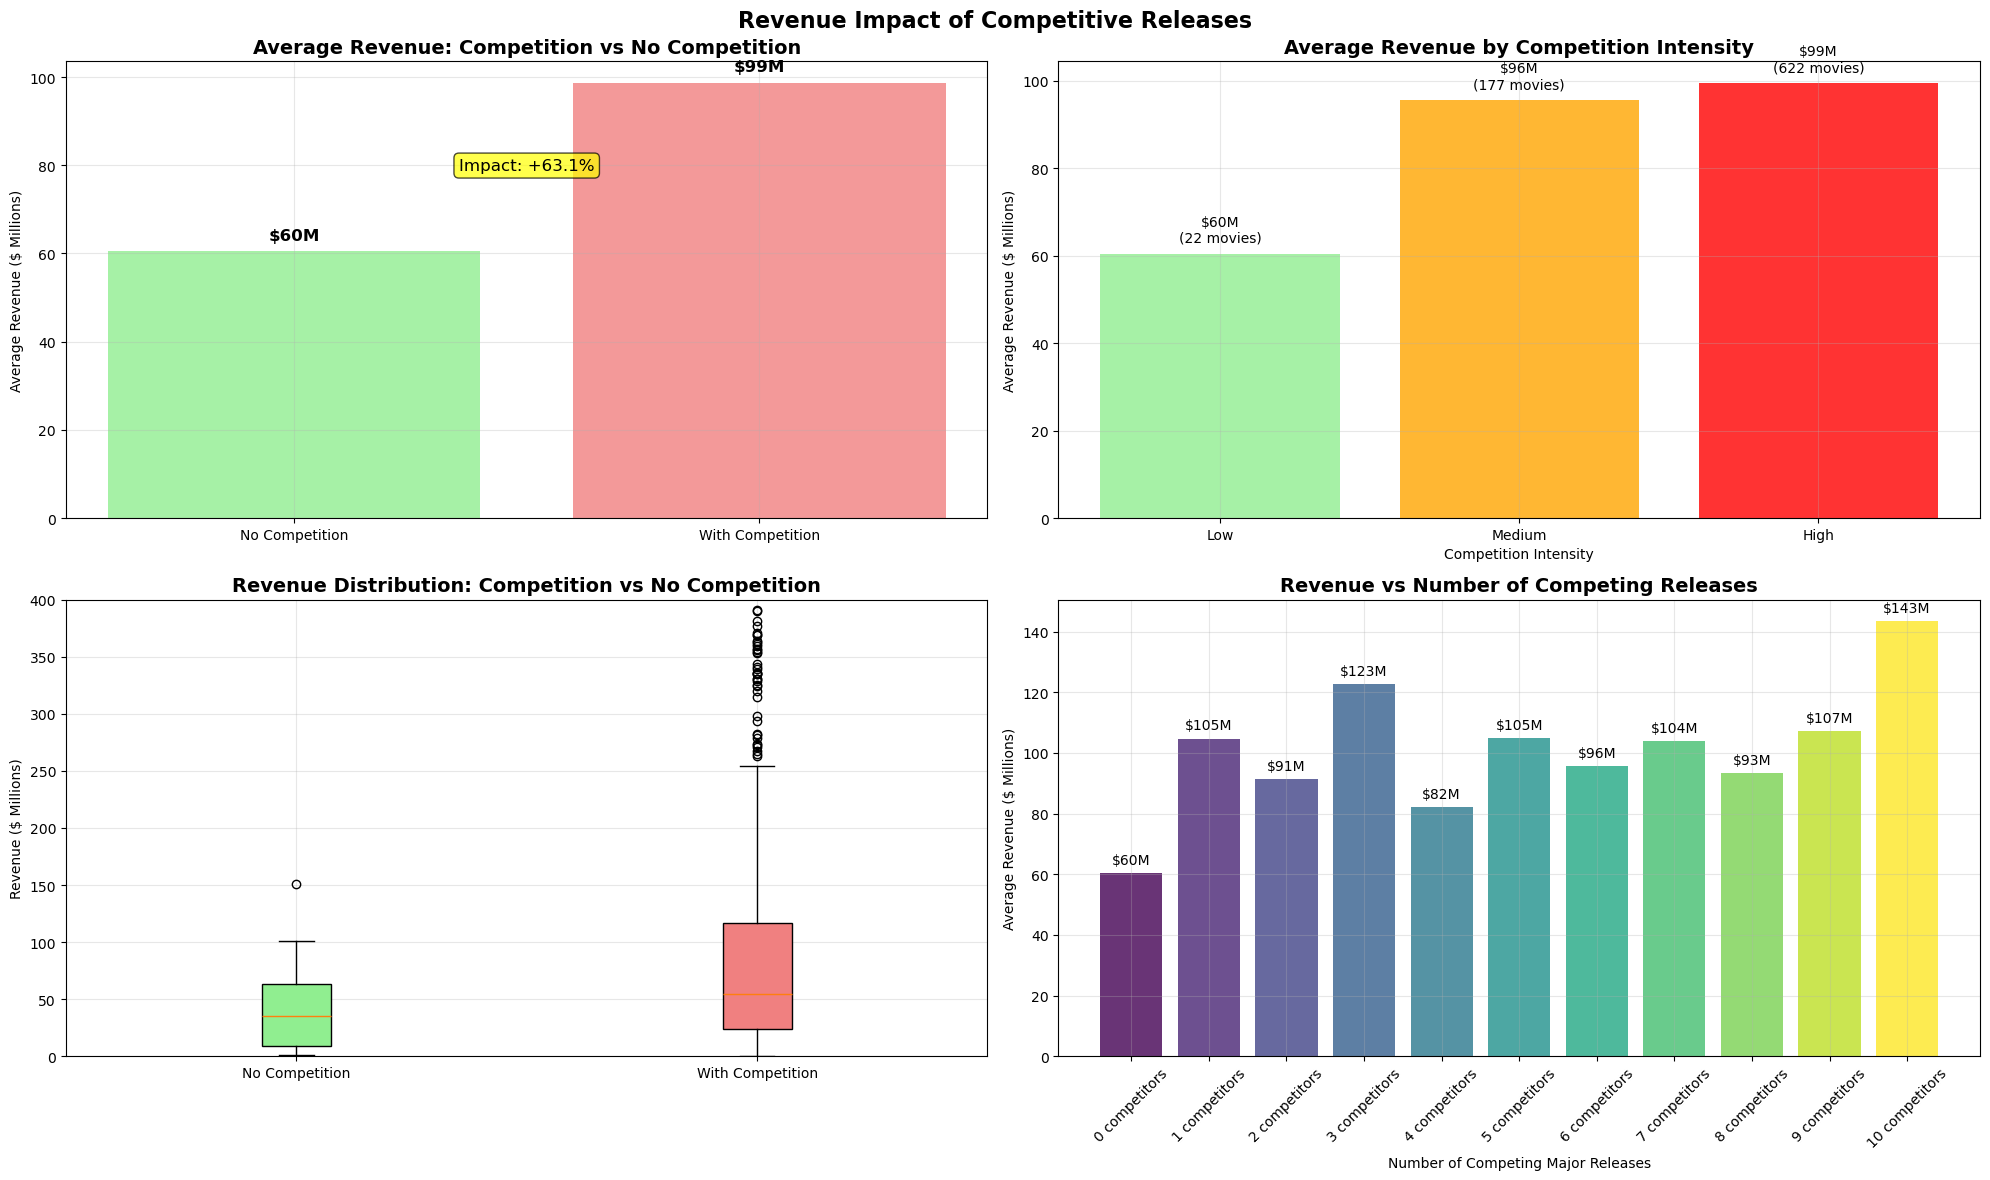


🎬 Competition Impact Insights:
Blockbuster competition impact:
Against blockbuster (200M+): $92M avg
No blockbuster competition: $106M avg
Blockbuster competition impact: -13.7%

Immediate competition impact (≤7 days):
Immediate competition: $97M avg
No immediate competition: $103M avg
Immediate competition impact: -6.1%


In [7]:
### Competition Impact Visualizations
if df['has_nearby_major_release'].sum() > 0:
    print(f"\nCompetition intensity distribution:")
    intensity_counts = df['competition_intensity'].value_counts()
    print(intensity_counts)
    
    print(f"\nCompetition statistics:")
    avg_nearby = df[df['has_nearby_major_release'] == 1]['nearby_major_releases_count'].mean()
    max_nearby = df['nearby_major_releases_count'].max()
    print(f"Average nearby major releases: {avg_nearby:.1f}")
    print(f"Maximum nearby major releases: {int(max_nearby)}")
    
    print(f"\nSpecific competition flags:")
    print(f"Has blockbuster competition (200M+): {df['has_blockbuster_competition'].sum()}")
    print(f"Has immediate competition (≤7 days): {df['has_immediate_competition'].sum()}")
    
    # Revenue impact analysis
    no_competition_avg = df[df['has_nearby_major_release'] == 0]['revenue_domestic'].mean()
    with_competition_avg = df[df['has_nearby_major_release'] == 1]['revenue_domestic'].mean()
    
    print(f"\nRevenue impact of competition:")
    print(f"No nearby competition: ${no_competition_avg/1e6:.1f}M avg")
    print(f"With nearby competition: ${with_competition_avg/1e6:.1f}M avg")
    if no_competition_avg > 0:
        impact = (with_competition_avg/no_competition_avg - 1) * 100
        print(f"Competition impact: {impact:+.1f}%")
    
    # Competition by intensity
    print(f"\nRevenue by competition intensity:")
    for intensity in ['Low', 'Medium', 'High']:
        if intensity in df['competition_intensity'].values:
            intensity_avg = df[df['competition_intensity'] == intensity]['revenue_domestic'].mean()
            intensity_count = (df['competition_intensity'] == intensity).sum()
            print(f"{intensity}: ${intensity_avg/1e6:.1f}M avg ({intensity_count} movies)")

# Sample movies with high competition
print(f"\nSample movies with high competition:")
high_competition = df[df['nearby_major_releases_count'] >= 2][
    ['title', 'release_date', 'revenue_domestic', 'nearby_major_releases_count', 
     'nearby_major_releases_max_revenue', 'days_to_nearest_major_release']
].head(10)

if len(high_competition) > 0:
    print(high_competition.to_string())
else:
    print("No movies found with high competition (2+ nearby major releases)")


if df['has_nearby_major_release'].sum() > 0:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Revenue Impact of Competitive Releases', fontsize=16, fontweight='bold')
    
    # 1. Competition vs No Competition Revenue Comparison
    ax1 = axes[0, 0]
    competition_data = ['No Competition', 'With Competition']
    competition_revenues = [no_competition_avg / 1e6, with_competition_avg / 1e6]
    competition_colors = ['lightgreen', 'lightcoral']
    
    bars1 = ax1.bar(competition_data, competition_revenues, color=competition_colors, alpha=0.8)
    ax1.set_title('Average Revenue: Competition vs No Competition', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Average Revenue ($ Millions)')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels and percentage difference
    for bar, value in zip(bars1, competition_revenues):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                f'${value:.0f}M', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add percentage difference annotation
    if no_competition_avg > 0:
        pct_diff = (with_competition_avg/no_competition_avg - 1) * 100
        ax1.text(0.5, max(competition_revenues) * 0.8, f'Impact: {pct_diff:+.1f}%', 
                ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # 2. Revenue by Competition Intensity
    ax2 = axes[0, 1]
    intensity_order = ['Low', 'Medium', 'High']
    intensity_revenues = []
    intensity_counts = []
    
    for intensity in intensity_order:
        if intensity in df['competition_intensity'].values:
            intensity_avg = df[df['competition_intensity'] == intensity]['revenue_domestic'].mean()
            intensity_count = (df['competition_intensity'] == intensity).sum()
            intensity_revenues.append(intensity_avg / 1e6)
            intensity_counts.append(intensity_count)
        else:
            intensity_revenues.append(0)
            intensity_counts.append(0)
    
    intensity_colors = ['lightgreen', 'orange', 'red']
    bars2 = ax2.bar(intensity_order, intensity_revenues, color=intensity_colors, alpha=0.8)
    ax2.set_title('Average Revenue by Competition Intensity', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Revenue ($ Millions)')
    ax2.set_xlabel('Competition Intensity')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value, count in zip(bars2, intensity_revenues, intensity_counts):
        if value > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                    f'${value:.0f}M\n({count} movies)', ha='center', va='bottom', fontsize=10)
    
    # 3. Box Plot: Revenue Distribution by Competition Status
    ax3 = axes[1, 0]
    
    box_data = [
        df[df['has_nearby_major_release'] == 0]['revenue_domestic'] / 1e6,
        df[df['has_nearby_major_release'] == 1]['revenue_domestic'] / 1e6
    ]
    box_labels = ['No Competition', 'With Competition']
    
    bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax3.set_title('Revenue Distribution: Competition vs No Competition', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Revenue ($ Millions)')
    ax3.set_ylim(0, 400)  # Limit for better visualization
    ax3.grid(True, alpha=0.3)
    
    # 4. Revenue vs Number of Competing Releases
    ax4 = axes[1, 1]
    
    # Group by number of competing releases
    competition_counts = df['nearby_major_releases_count'].value_counts().sort_index()
    count_revenues = []
    count_labels = []
    
    for count in range(int(df['nearby_major_releases_count'].max()) + 1):
        if count in competition_counts.index and competition_counts[count] >= 3:  # At least 3 movies
            avg_rev = df[df['nearby_major_releases_count'] == count]['revenue_domestic'].mean()
            count_revenues.append(avg_rev / 1e6)
            count_labels.append(f'{count} competitors')
    
    if len(count_revenues) > 1:
        colors = plt.cm.viridis(np.linspace(0, 1, len(count_labels)))
        bars4 = ax4.bar(count_labels, count_revenues, color=colors, alpha=0.8)
        ax4.set_title('Revenue vs Number of Competing Releases', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Average Revenue ($ Millions)')
        ax4.set_xlabel('Number of Competing Major Releases')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars4, count_revenues):
            ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                    f'${value:.0f}M', ha='center', va='bottom', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'Insufficient data for\ncompetition count analysis', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Revenue vs Number of Competing Releases', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Additional insights
    print(f"\n🎬 Competition Impact Insights:")
    print("=" * 50)
    
    # Blockbuster competition analysis
    if df['has_blockbuster_competition'].sum() > 0:
        blockbuster_comp_avg = df[df['has_blockbuster_competition'] == 1]['revenue_domestic'].mean()
        non_blockbuster_comp_avg = df[df['has_blockbuster_competition'] == 0]['revenue_domestic'].mean()
        
        print(f"Blockbuster competition impact:")
        print(f"Against blockbuster (200M+): ${blockbuster_comp_avg/1e6:.0f}M avg")
        print(f"No blockbuster competition: ${non_blockbuster_comp_avg/1e6:.0f}M avg")
        if non_blockbuster_comp_avg > 0:
            blockbuster_impact = (blockbuster_comp_avg/non_blockbuster_comp_avg - 1) * 100
            print(f"Blockbuster competition impact: {blockbuster_impact:+.1f}%")
    
    # Immediate competition analysis
    if df['has_immediate_competition'].sum() > 0:
        immediate_comp_avg = df[df['has_immediate_competition'] == 1]['revenue_domestic'].mean()
        non_immediate_comp_avg = df[df['has_immediate_competition'] == 0]['revenue_domestic'].mean()
        
        print(f"\nImmediate competition impact (≤7 days):")
        print(f"Immediate competition: ${immediate_comp_avg/1e6:.0f}M avg")
        print(f"No immediate competition: ${non_immediate_comp_avg/1e6:.0f}M avg")
        if non_immediate_comp_avg > 0:
            immediate_impact = (immediate_comp_avg/non_immediate_comp_avg - 1) * 100
            print(f"Immediate competition impact: {immediate_impact:+.1f}%")

else:
    print("\nNo competitive releases found for visualization")

### IP and Sequels

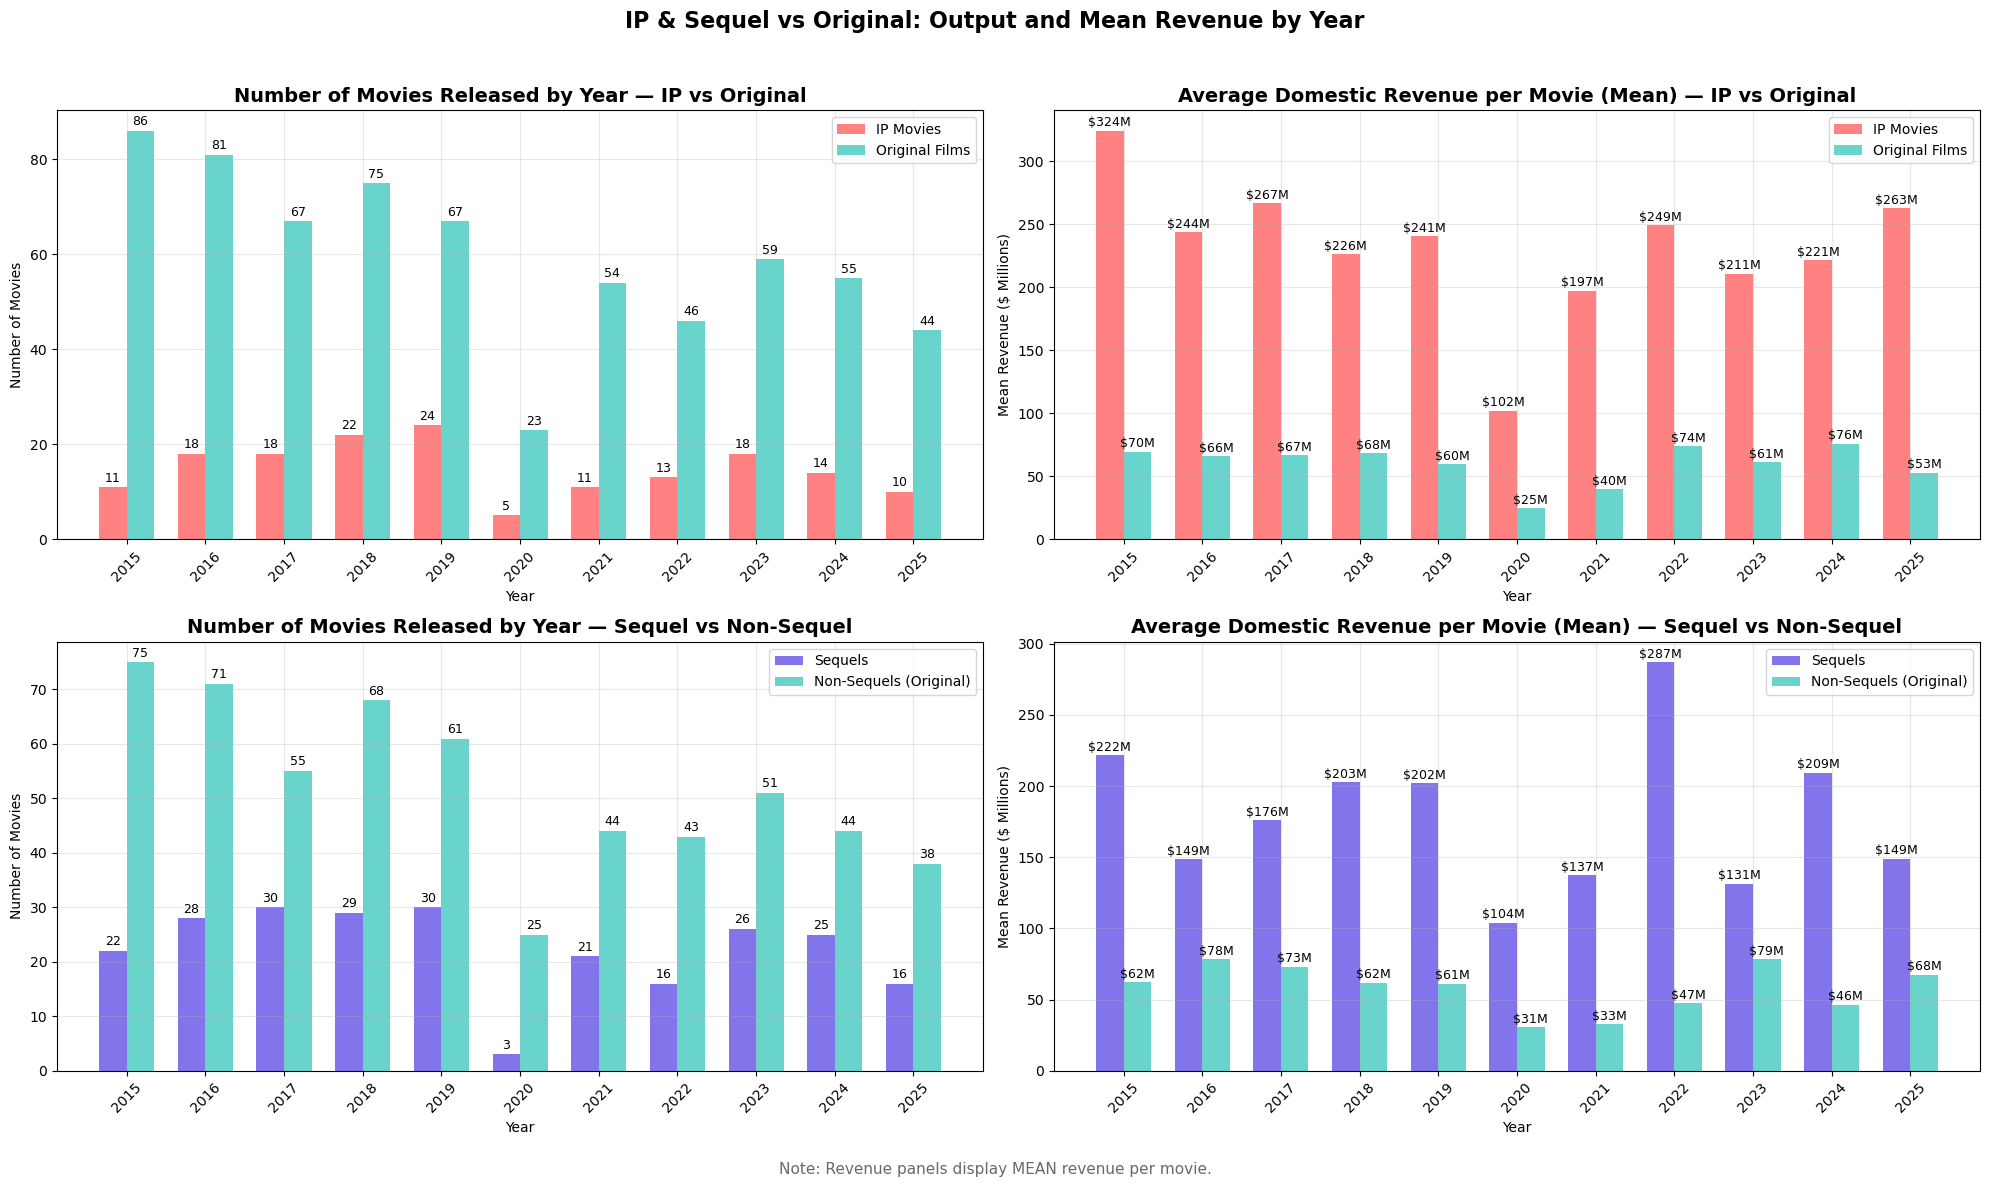

In [8]:
# Get unique years for analysis
years = sorted(df['release_year'].unique())

# ---- Build IP vs Original by year ----
ip_vs_original_data = []
for year in years:
    year_data = df[df['release_year'] == year]
    
    ip = year_data[year_data['is_ip_movie'] == 1]
    original = year_data[year_data['is_ip_movie'] == 0]
    
    ip_count = len(ip)
    original_count = len(original)
    ip_avg = ip['revenue_domestic'].mean() if ip_count > 0 else 0
    original_avg = original['revenue_domestic'].mean() if original_count > 0 else 0
    
    ip_vs_original_data.append({
        'year': year,
        'ip_count': ip_count,
        'original_count': original_count,
        'ip_avg_revenue': ip_avg,
        'original_avg_revenue': original_avg
    })

ip_df = pd.DataFrame(ip_vs_original_data).set_index('year').reindex(years).fillna(0)

# ---- Build sequel vs non-sequel by year (to compare against "original" films) ----
seq_vs_nonseq_data = []
for year in years:
    year_data = df[df['release_year'] == year]

    seq = year_data[year_data['is_sequel'] == 1]
    nonseq = year_data[year_data['is_sequel'] == 0]  # includes originals / non-sequels

    seq_count = len(seq)
    nonseq_count = len(nonseq)
    seq_avg = seq['revenue_domestic'].mean() if seq_count > 0 else 0
    nonseq_avg = nonseq['revenue_domestic'].mean() if nonseq_count > 0 else 0

    seq_vs_nonseq_data.append({
        'year': year,
        'sequel_count': seq_count,
        'nonsequel_count': nonseq_count,
        'sequel_avg_revenue': seq_avg,
        'nonsequel_avg_revenue': nonseq_avg
    })

seq_df = pd.DataFrame(seq_vs_nonseq_data).set_index('year').reindex(years).fillna(0)

# ---- Visualization: IP vs Original (top) and Sequel vs Non-Sequel (bottom) ----
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('IP & Sequel vs Original: Output and Mean Revenue by Year', fontsize=16, fontweight='bold')

x = np.arange(len(years))
width = 0.35

# Colors
ip_color = '#FF6B6B'        # IP
original_color = '#4ECDC4'  # Original / Non-Sequel
sequel_color = '#6C5CE7'    # Sequel

# ---------- TOP: IP vs Original ----------
# 1) Number of IP vs Original (TOP-LEFT)
ax1 = axes[0, 0]
bars1 = ax1.bar(x - width/2, ip_df['ip_count'].values, width, label='IP Movies', color=ip_color, alpha=0.85)
bars2 = ax1.bar(x + width/2, ip_df['original_count'].values, width, label='Original Films', color=original_color, alpha=0.85)
ax1.set_title('Number of Movies Released by Year — IP vs Original', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year'); ax1.set_ylabel('Number of Movies')
ax1.set_xticks(x); ax1.set_xticklabels(years, rotation=45)
ax1.legend(); ax1.grid(True, alpha=0.3)
for bars in (bars1, bars2):
    for b in bars:
        h = b.get_height()
        if h > 0:
            ax1.text(b.get_x() + b.get_width()/2, h + 0.5, f'{int(h)}', ha='center', va='bottom', fontsize=9)

# 2) Average revenue per movie (MEAN) — IP vs Original (TOP-RIGHT)
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, (ip_df['ip_avg_revenue'] / 1e6).values, width, label='IP Movies', color=ip_color, alpha=0.85)
bars4 = ax2.bar(x + width/2, (ip_df['original_avg_revenue'] / 1e6).values, width, label='Original Films', color=original_color, alpha=0.85)
ax2.set_title('Average Domestic Revenue per Movie (Mean) — IP vs Original', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year'); ax2.set_ylabel('Mean Revenue ($ Millions)')
ax2.set_xticks(x); ax2.set_xticklabels(years, rotation=45)
ax2.legend(); ax2.grid(True, alpha=0.3)
for bars in (bars3, bars4):
    for b in bars:
        h = b.get_height()
        if h > 0:
            ax2.text(b.get_x() + b.get_width()/2, h + 1, f'${h:.0f}M', ha='center', va='bottom', fontsize=9)

# ---------- BOTTOM: Sequel vs Non-Sequel (Original) ----------
# 3) Number of Sequels vs Non-Sequels (BOTTOM-LEFT)
ax3 = axes[1, 0]
bars5 = ax3.bar(x - width/2, seq_df['sequel_count'].values, width, label='Sequels', color=sequel_color, alpha=0.85)
bars6 = ax3.bar(x + width/2, seq_df['nonsequel_count'].values, width, label='Non-Sequels (Original)', color=original_color, alpha=0.85)
ax3.set_title('Number of Movies Released by Year — Sequel vs Non-Sequel', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year'); ax3.set_ylabel('Number of Movies')
ax3.set_xticks(x); ax3.set_xticklabels(years, rotation=45)
ax3.legend(); ax3.grid(True, alpha=0.3)
for bars in (bars5, bars6):
    for b in bars:
        h = b.get_height()
        if h > 0:
            ax3.text(b.get_x() + b.get_width()/2, h + 0.5, f'{int(h)}', ha='center', va='bottom', fontsize=9)

# 4) Average revenue per movie (MEAN) — Sequel vs Non-Sequel (BOTTOM-RIGHT)
ax4 = axes[1, 1]
bars7 = ax4.bar(x - width/2, (seq_df['sequel_avg_revenue'] / 1e6).values, width, label='Sequels', color=sequel_color, alpha=0.85)
bars8 = ax4.bar(x + width/2, (seq_df['nonsequel_avg_revenue'] / 1e6).values, width, label='Non-Sequels (Original)', color=original_color, alpha=0.85)
ax4.set_title('Average Domestic Revenue per Movie (Mean) — Sequel vs Non-Sequel', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year'); ax4.set_ylabel('Mean Revenue ($ Millions)')
ax4.set_xticks(x); ax4.set_xticklabels(years, rotation=45)
ax4.legend(); ax4.grid(True, alpha=0.3)
for bars in (bars7, bars8):
    for b in bars:
        h = b.get_height()
        if h > 0:
            ax4.text(b.get_x() + b.get_width()/2, h + 1, f'${h:.0f}M', ha='center', va='bottom', fontsize=9)

# Clarify measure used
fig.text(0.5, 0.01, 'Note: Revenue panels display MEAN revenue per movie.', ha='center', fontsize=11, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### Era Analysis (Using Alternative Time Features)

📊 Industry Era Analysis (Alternative Time Features)
Yearly Statistics (for reference):
              Movie_Count  Mean_Revenue  Median_Revenue   Std_Revenue  \
release_year                                                            
2015                   97  9.847013e+07      56451232.0  1.343151e+08   
2016                   99  9.824853e+07      61433527.0  1.089890e+08   
2017                   85  1.092964e+08      63859435.0  1.201103e+08   
2018                   97  1.040550e+08      58032443.0  1.284435e+08   
2019                   91  1.075806e+08      56846802.0  1.433280e+08   
2020                   28  3.858725e+07      16381926.5  4.759159e+07   
2021                   65  6.659511e+07      38014727.0  1.090373e+08   
2022                   59  1.123562e+08      50057405.0  1.579131e+08   
2023                   77  9.638887e+07      63973821.0  1.169698e+08   
2024                   69  1.054783e+08      43817106.0  1.415792e+08   
2025                   54  9.168052e+

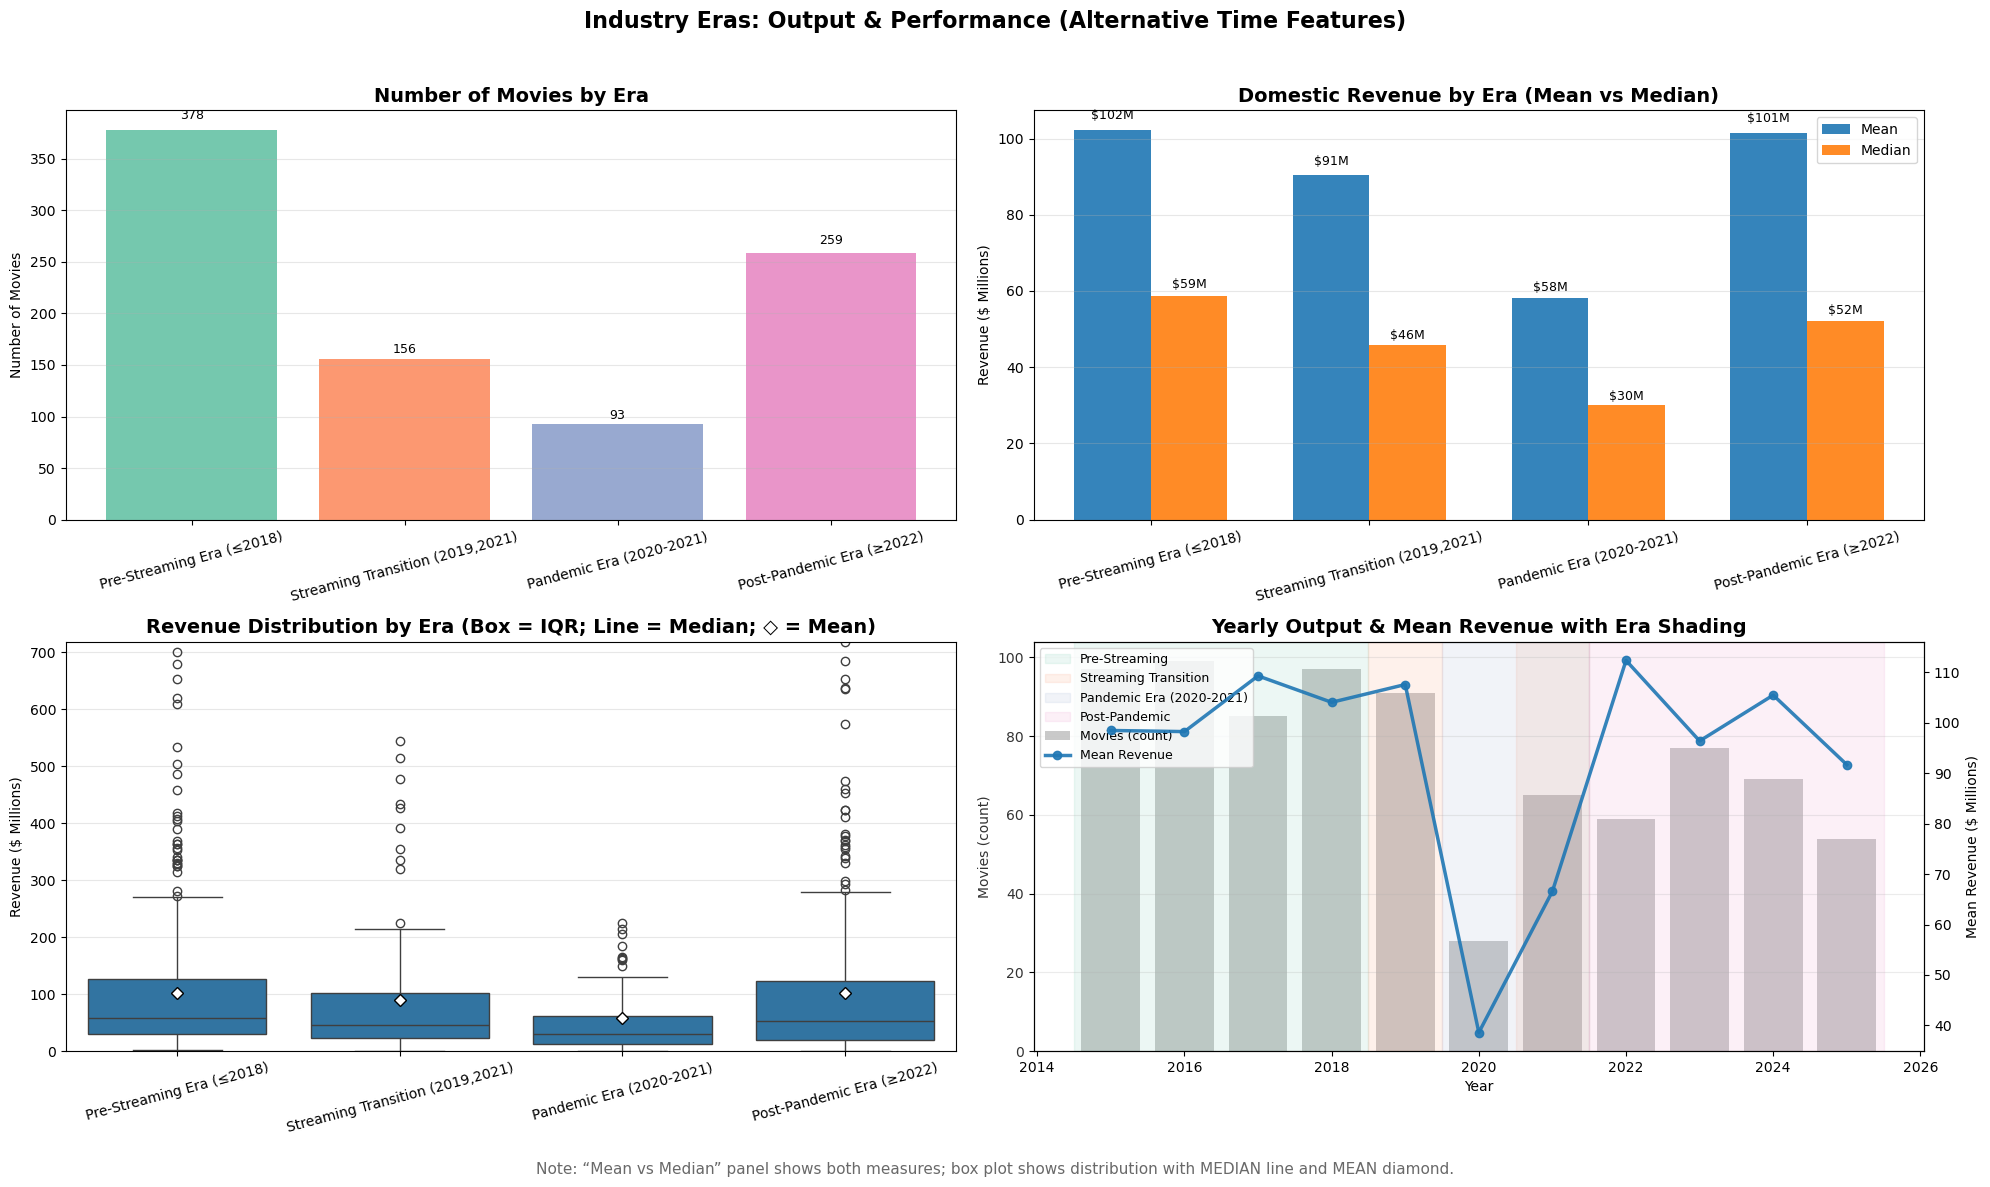

In [9]:
# Analyze industry eras using alternative time features
print("📊 Industry Era Analysis (Alternative Time Features)")
print("=" * 60)

# Calculate yearly statistics (keep for reference)
yearly_analysis = df.groupby('release_year').agg({
    'revenue_domestic': ['count', 'mean', 'median', 'std', 'max'],
    'is_major_studio': 'mean'
}).round(2)

yearly_analysis.columns = ['Movie_Count', 'Mean_Revenue', 'Median_Revenue', 'Std_Revenue', 'Max_Revenue', 'Major_Studio_Pct']
print("Yearly Statistics (for reference):")
print(yearly_analysis)

# Analyze by era features (our new approach)
print(f"\n🎭 ERA-BASED ANALYSIS (Using Alternative Time Features):")
print("=" * 60)

era_analysis = {
    'Pre-Streaming Era (≤2018)': df[df['is_pre_streaming_era'] == 1],
    'Streaming Transition (2019,2021)': df[df['is_streaming_transition'] == 1],
    'Pandemic Era (2020-2021)': df[df['is_pandemic_year'] == 1],
    'Post-Pandemic Era (≥2022)': df[df['is_post_pandemic_era'] == 1]
}

for era_name, era_data in era_analysis.items():
    if len(era_data) > 0:
        count = len(era_data)
        avg_revenue = era_data['revenue_domestic'].mean()
        median_revenue = era_data['revenue_domestic'].median()
        max_revenue = era_data['revenue_domestic'].max()
        
        print(f"\n{era_name}:")
        print(f"  Movies: {count}")
        print(f"  Average revenue: ${avg_revenue:,.0f}")
        print(f"  Median revenue: ${median_revenue:,.0f}")
        print(f"  Max revenue: ${max_revenue:,.0f}")

# Compare era performance
pre_streaming_avg = era_analysis['Pre-Streaming Era (≤2018)']['revenue_domestic'].mean()
pandemic_avg = era_analysis['Pandemic Era (2020-2021)']['revenue_domestic'].mean()
post_pandemic_avg = era_analysis['Post-Pandemic Era (≥2022)']['revenue_domestic'].mean()

print(f"\n💡 Era Impact Analysis:")
print(f"Pre-streaming avg:   ${pre_streaming_avg:,.0f} (baseline)")
print(f"Pandemic impact:     ${pandemic_avg:,.0f} ({(pandemic_avg/pre_streaming_avg-1)*100:+.1f}%)")
print(f"Post-pandemic:       ${post_pandemic_avg:,.0f} ({(post_pandemic_avg/pre_streaming_avg-1)*100:+.1f}%)")

# Show top movies for each era
print(f"\n🎬 Top 3 Movies by Era:")
for era_name, era_data in era_analysis.items():
    if len(era_data) >= 3:
        top_movies = era_data.nlargest(3, 'revenue_domestic')[['title', 'revenue_domestic']]
        print(f"\n{era_name}:")
        for i, (_, row) in enumerate(top_movies.iterrows(), 1):
            print(f"  {i}. {row['title']}: ${row['revenue_domestic']:,.0f}")

# Show year distribution
year_counts = df.groupby('release_year').size()
print(f"\nMajor studio movies by year:")
for year in sorted(year_counts.index):
    print(f"  {year}: {year_counts[year]} movies")

# Show distribution of alternative time features
print(f"\nTime feature distributions:")
print(f"  years_since_baseline: {df['years_since_baseline'].min()} to {df['years_since_baseline'].max()}")
print(f"  Pre-streaming era (≤2018): {df['is_pre_streaming_era'].sum()} movies")
print(f"  Streaming transition (2019,2021): {df['is_streaming_transition'].sum()} movies")
print(f"  Pandemic years (2020-2021): {df['is_pandemic_year'].sum()} movies")
print(f"  Post-pandemic era (≥2022): {df['is_post_pandemic_era'].sum()} movies")


# ========= Era Visualizations =========
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare tidy era stats
era_order = [
    'Pre-Streaming Era (≤2018)',
    'Streaming Transition (2019,2021)',
    'Pandemic Era (2020-2021)',
    'Post-Pandemic Era (≥2022)'
]

era_stats = []
for era_name in era_order:
    edf = era_analysis[era_name]
    if len(edf) == 0:
        era_stats.append({'era': era_name, 'count': 0, 'mean_rev': 0.0, 'median_rev': 0.0, 'max_rev': 0.0})
    else:
        era_stats.append({
            'era': era_name,
            'count': len(edf),
            'mean_rev': edf['revenue_domestic'].mean(),
            'median_rev': edf['revenue_domestic'].median(),
            'max_rev': edf['revenue_domestic'].max()
        })

era_df = pd.DataFrame(era_stats).set_index('era').loc[era_order]

# Colors per era (Set2-like)
era_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']  # 4 eras
era_color_map = dict(zip(era_order, era_colors))

# Figure
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Industry Eras: Output & Performance (Alternative Time Features)', fontsize=16, fontweight='bold')

# ----- Top-Left: Number of movies by era -----
ax1 = axes[0, 0]
bars1 = ax1.bar(era_df.index, era_df['count'].values,
                color=[era_color_map[e] for e in era_df.index], alpha=0.9)
ax1.set_title('Number of Movies by Era', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Movies')
ax1.tick_params(axis='x', rotation=15)
ax1.grid(True, axis='y', alpha=0.3)
for b, v in zip(bars1, era_df['count'].values):
    if v > 0:
        ax1.text(b.get_x() + b.get_width()/2, v + max(1, v*0.02), f'{int(v)}',
                 ha='center', va='bottom', fontsize=9)

# ----- Top-Right: Mean vs Median revenue by era -----
ax2 = axes[0, 1]
x = np.arange(len(era_df))
w = 0.35
mean_mill = era_df['mean_rev'].values / 1e6
median_mill = era_df['median_rev'].values / 1e6

bars_mean = ax2.bar(x - w/2, mean_mill, w, label='Mean', color='#1f77b4', alpha=0.9)
bars_median = ax2.bar(x + w/2, median_mill, w, label='Median', color='#ff7f0e', alpha=0.9)

ax2.set_title('Domestic Revenue by Era (Mean vs Median)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Revenue ($ Millions)')
ax2.set_xticks(x); ax2.set_xticklabels(era_df.index, rotation=15)
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)
for b, v in zip(bars_mean, mean_mill):
    if v > 0:
        ax2.text(b.get_x() + b.get_width()/2, v + max(0.5, v*0.02), f'${v:.0f}M',
                 ha='center', va='bottom', fontsize=9)
for b, v in zip(bars_median, median_mill):
    if v > 0:
        ax2.text(b.get_x() + b.get_width()/2, v + max(0.5, v*0.02), f'${v:.0f}M',
                 ha='center', va='bottom', fontsize=9)

# ----- Bottom-Left: Distribution by era (Box = IQR; Line = Median; ◇ = Mean) -----
ax3 = axes[1, 0]

# Build a long-form DataFrame (era, revenue in $M)
era_long_parts = []
for era_name in era_order:
    edf = era_analysis[era_name]
    if len(edf) > 0:
        tmp = edf[['revenue_domestic']].copy()
        tmp['era'] = era_name
        tmp['rev_mill'] = tmp['revenue_domestic'] / 1e6
        era_long_parts.append(tmp[['era', 'rev_mill']])

if era_long_parts:
    era_long = pd.concat(era_long_parts, ignore_index=True)

    sns.boxplot(
        data=era_long, x='era', y='rev_mill', order=era_order, ax=ax3,
        showmeans=True,
        meanprops={"marker": "D", "markersize": 6,
                   "markerfacecolor": "white", "markeredgecolor": "black"}
    )
    ax3.set_title('Revenue Distribution by Era (Box = IQR; Line = Median; ◇ = Mean)',
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel('')
    ax3.set_ylabel('Revenue ($ Millions)')
    ax3.tick_params(axis='x', rotation=15)
    ax3.grid(True, axis='y', alpha=0.3)

    # Optional: cap y-axis to reduce the influence of extreme outliers
    y_max = np.nanpercentile(era_long['rev_mill'], 99)
    ax3.set_ylim(0, max(100, y_max * 1.1))
else:
    ax3.text(0.5, 0.5, 'Insufficient data for distribution plot',
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Revenue Distribution by Era', fontsize=14, fontweight='bold')

# ----- Bottom-Right: Yearly trend w/ era shading -----
ax4 = axes[1, 1]
# Bars: yearly movie count
years_sorted = sorted(yearly_analysis.index.tolist())
counts = df.groupby('release_year').size().reindex(years_sorted, fill_value=0).values
bars_year = ax4.bar(years_sorted, counts, color='#b3b3b3', alpha=0.7, label='Movies (count)')

ax4.set_xlabel('Year')
ax4.set_ylabel('Movies (count)', color='#333333')
ax4.tick_params(axis='y', labelcolor='#333333')
ax4.set_title('Yearly Output & Mean Revenue with Era Shading', fontsize=14, fontweight='bold')
ax4.grid(True, axis='y', alpha=0.25)

# Line: yearly mean revenue (Millions) on secondary axis
ax4b = ax4.twinx()
mean_rev_year_mill = (yearly_analysis['Mean_Revenue'] / 1e6).reindex(years_sorted).values
ax4b.plot(years_sorted, mean_rev_year_mill, marker='o', linewidth=2.5, label='Mean Revenue', alpha=0.9)
ax4b.set_ylabel('Mean Revenue ($ Millions)')
ax4b.grid(False)

# Era shading (x spans)
def shade_span(ax, start, end, color, label=None):
    ax.axvspan(start-0.5, end+0.5, color=color, alpha=0.12, label=label)

if len(years_sorted) > 0:
    y_min, y_max = min(years_sorted), max(years_sorted)
    # Pre-Streaming ≤2018
    if y_min <= 2018:
        shade_span(ax4, y_min, min(2018, y_max), era_color_map['Pre-Streaming Era (≤2018)'], label='Pre-Streaming')
    # Streaming Transition (2019 & 2021)
    if 2019 in years_sorted:
        shade_span(ax4, 2019, 2019, era_color_map['Streaming Transition (2019,2021)'], label='Streaming Transition')
    if 2021 in years_sorted:
        shade_span(ax4, 2021, 2021, era_color_map['Streaming Transition (2019,2021)'])
    # Pandemic Era (2020-2021)
    if 2020 in years_sorted or 2021 in years_sorted:
        start = 2020 if 2020 in years_sorted else min(years_sorted)
        end = 2021 if 2021 in years_sorted else 2020
        shade_span(ax4, start, end, era_color_map['Pandemic Era (2020-2021)'], label='Pandemic Era (2020-2021)')
    # Post-Pandemic ≥2022
    if y_max >= 2022:
        shade_span(ax4, max(2022, y_min), y_max, era_color_map['Post-Pandemic Era (≥2022)'], label='Post-Pandemic')

# Compose a single legend for the shaded spans + line
handles1, labels1 = ax4.get_legend_handles_labels()
handles2, labels2 = ax4b.get_legend_handles_labels()
by_label = dict(zip(labels1 + labels2, handles1 + handles2))
ax4.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=9)

# Figure note clarifying center measures
fig.text(0.5, 0.01,
         'Note: “Mean vs Median” panel shows both measures; box plot shows distribution with MEDIAN line and MEAN diamond.',
         ha='center', fontsize=11, color='dimgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()
